In [15]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import plotly.graph_objects as go

df = pd.read_csv('./netflix-dataset/netflix_titles.csv')

In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8807 entries, 0 to 8806
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   show_id       8807 non-null   object
 1   type          8807 non-null   object
 2   title         8807 non-null   object
 3   director      6173 non-null   object
 4   cast          7982 non-null   object
 5   country       7976 non-null   object
 6   date_added    8797 non-null   object
 7   release_year  8807 non-null   int64 
 8   rating        8803 non-null   object
 9   duration      8804 non-null   object
 10  listed_in     8807 non-null   object
 11  description   8807 non-null   object
dtypes: int64(1), object(11)
memory usage: 825.8+ KB


## Network Graph

In [19]:
df_net = df.dropna(subset=['director', 'listed_in']).copy()
df_net['genre'] = df_net['listed_in'].apply(lambda x: x.split(', ')[0])
df_net['director'] = df_net['director'].apply(lambda x: x.split(',')[0] if ',' in x else x)

In [21]:
df_net.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6173 entries, 0 to 8806
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   show_id       6173 non-null   object
 1   type          6173 non-null   object
 2   title         6173 non-null   object
 3   director      6173 non-null   object
 4   cast          5700 non-null   object
 5   country       5751 non-null   object
 6   date_added    6173 non-null   object
 7   release_year  6173 non-null   int64 
 8   rating        6172 non-null   object
 9   duration      6170 non-null   object
 10  listed_in     6173 non-null   object
 11  description   6173 non-null   object
 12  genre         6173 non-null   object
dtypes: int64(1), object(12)
memory usage: 675.2+ KB


In [23]:
collab_df = df_net.groupby(['director', 'genre']).size().reset_index(name='count')
top_directors = collab_df.groupby('director')['count'].sum().nlargest(20).index
collab_df = collab_df[collab_df['director'].isin(top_directors)]

In [25]:
G = nx.Graph()
for _, row in collab_df.iterrows():
    G.add_node(row['director'], type='director')
    G.add_node(row['genre'], type='genre')
    G.add_edge(row['director'], row['genre'], weight=row['count'])

In [27]:
pos = nx.spring_layout(G, k=0.5, seed=42)
node_colors = ['#e41a1c' if G.nodes[n]['type'] == 'director' else '#377eb8' for n in G.nodes]
node_sizes = [300 + 50 * G.degree(n) for n in G.nodes]

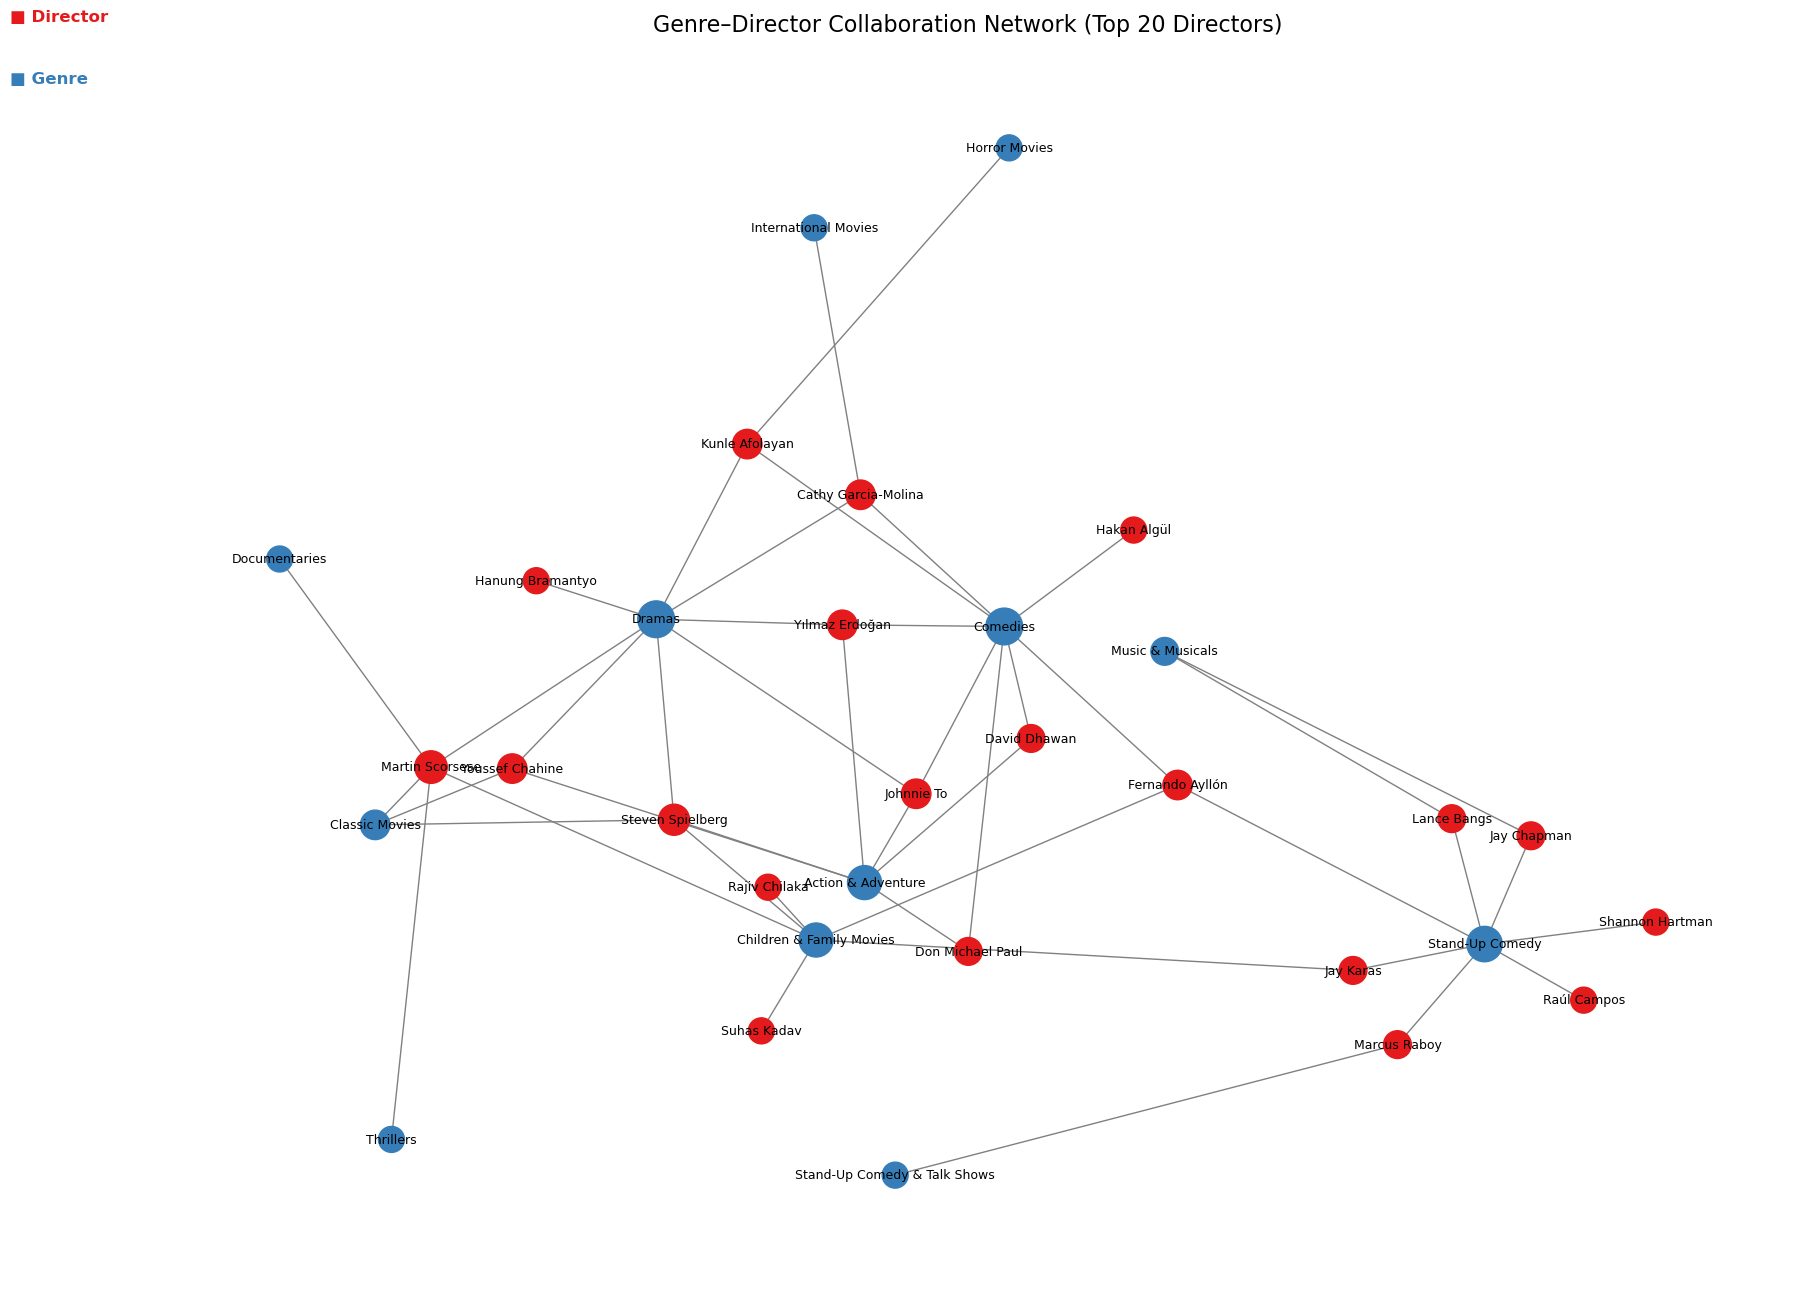

In [53]:
plt.figure(figsize=(18, 13))
nx.draw_networkx(
    G, pos, with_labels=True,
    node_color=node_colors, node_size=node_sizes,
    edge_color='gray', font_size=9
)
plt.title('Genre–Director Collaboration Network (Top 20 Directors)', fontsize=16)
plt.axis('off')

# Inline Legend (top left inside graph)
plt.text(-1.3, 1.2, '■ Director', fontsize=12, color='#e41a1c', weight='bold')
plt.text(-1.3, 1.1, '■ Genre', fontsize=12, color='#377eb8', weight='bold')

plt.tight_layout()
plt.show()

## Sankey Diagram

In [31]:
df_sankey = df.dropna(subset=['country', 'type', 'listed_in']).copy()
df_sankey['country'] = df_sankey['country'].apply(lambda x: x.split(',')[0].strip())
df_sankey['genre'] = df_sankey['listed_in'].apply(lambda x: x.split(',')[0])

In [33]:
df_sankey.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7976 entries, 0 to 8806
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   show_id       7976 non-null   object
 1   type          7976 non-null   object
 2   title         7976 non-null   object
 3   director      5751 non-null   object
 4   cast          7305 non-null   object
 5   country       7976 non-null   object
 6   date_added    7967 non-null   object
 7   release_year  7976 non-null   int64 
 8   rating        7973 non-null   object
 9   duration      7973 non-null   object
 10  listed_in     7976 non-null   object
 11  description   7976 non-null   object
 12  genre         7976 non-null   object
dtypes: int64(1), object(12)
memory usage: 872.4+ KB


In [35]:
grouped = df_sankey.groupby(['country', 'type', 'genre']).size().reset_index(name='count')
top_countries = grouped.groupby('country')['count'].sum().nlargest(10).index
grouped = grouped[grouped['country'].isin(top_countries)]

In [37]:
countries = grouped['country'].unique().tolist()
types = grouped['type'].unique().tolist()
genres = grouped['genre'].unique().tolist()
labels = countries + types + genres

In [39]:
def idx(name): return labels.index(name)

In [41]:
links1 = grouped.groupby(['country', 'type'])['count'].sum().reset_index()
links1['source'] = links1['country'].apply(idx)
links1['target'] = links1['type'].apply(idx) + len(countries)

links2 = grouped.groupby(['type', 'genre'])['count'].sum().reset_index()
links2['source'] = links2['type'].apply(idx) + len(countries)
links2['target'] = links2['genre'].apply(idx) + len(countries) + len(types)

In [43]:
source = pd.concat([links1['source'], links2['source']])
target = pd.concat([links1['target'], links2['target']])
value = pd.concat([links1['count'], links2['count']])

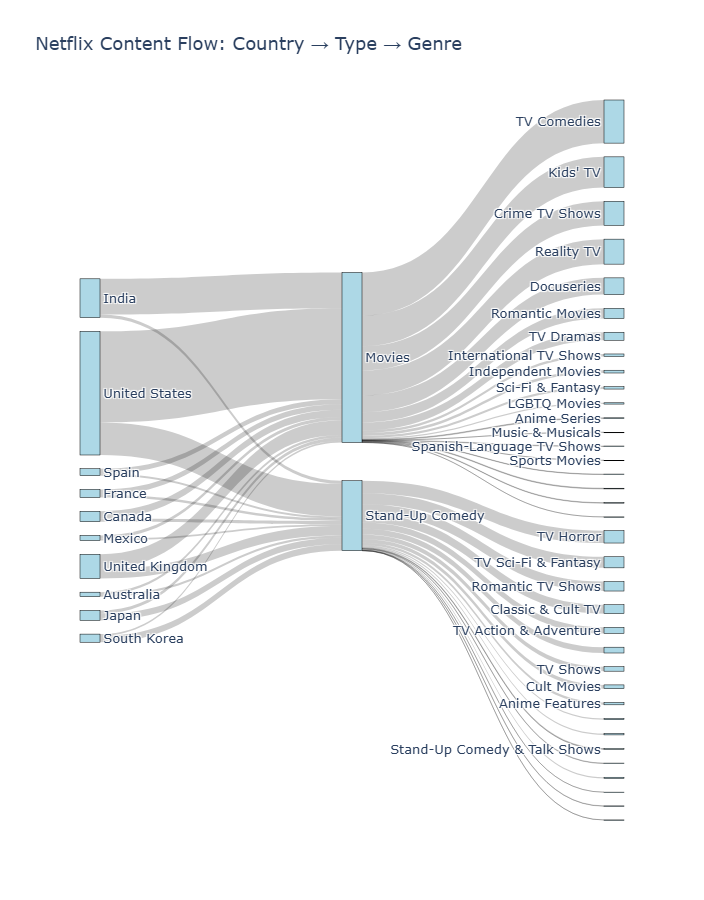

In [61]:
fig = go.Figure(data=[go.Sankey(
    arrangement='snap',
    node=dict(
        pad=15,
        thickness=20,
        line=dict(color='black', width=0.5),
        label=labels,
        color='lightblue'
    ),
    link=dict(
        source=source,
        target=target,
        value=value
    )
)])
fig.update_layout(
    title_text='Netflix Content Flow: Country → Type → Genre',
    font_size=13,
    height=900,  # Increased height for readability
    width=1000   # Increased width for readability
)
fig.show()